## IMDb

In [1]:
from fastai.text import *
import html

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

## Standardize format

In [ ]:
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [3]:
CLASSES = ['neg', 'pos']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return texts,labels

trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

In [4]:
len(trn_texts),len(val_texts)

(25000, 25000)

In [5]:
col_names = ['labels','text']

In [8]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [32]:
def get_texts(path):
    return [fname.open('r').read() for fname in (path/'all').glob('*.*')]

all_texts =  get_texts(PATH/'train')
all_texts += get_texts(PATH/'test')

In [33]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(all_texts, test_size=0.1)

In [34]:
len(trn_texts), len(val_texts)

(90000, 10000)

In [35]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language model tokens

In [36]:
chunksize=24000

In [37]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [38]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [39]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [40]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [41]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [42]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [43]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [ ]:
# trn_joined = [' '.join(o) for o in tok_trn]
# mdl_fn = f'{PATH}tmp/{pr_abbr}_joined.txt'
# open(mdl_fn, 'w', encoding='utf-8').writelines(trn_joined)

In [ ]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [44]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1210343),
 ('.', 992949),
 (',', 986569),
 ('and', 587674),
 ('a', 583580),
 ('of', 525539),
 ('to', 485458),
 ('is', 393569),
 ('it', 341409),
 ('in', 337946),
 ('i', 308226),
 ('this', 270821),
 ('that', 261198),
 ('"', 237159),
 ("'s", 221032),
 ('-', 188062),
 ('was', 180556),
 ('\n\n', 179179),
 ('as', 165827),
 ('with', 159218),
 ('for', 158785),
 ('movie', 157922),
 ('but', 150381),
 ('film', 144309),
 ('you', 124324)]

In [48]:
max_vocab = 60000
min_freq = 2

In [49]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [50]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [54]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

## Language model

In [8]:
wd=1e-7
bptt=70
bs=52
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [9]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [10]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*1.

In [15]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [13]:
learner.lr_find(start_lr=1e-6,end_lr=1e12)

A Jupyter Widget

 29%|██▊       | 1967/6872 [06:00<14:59,  5.45it/s, loss=7.06]

KeyboardInterrupt: 

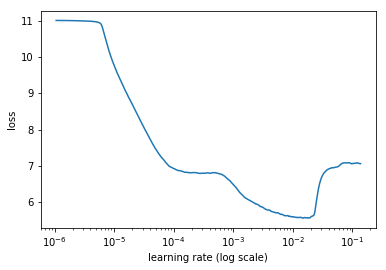

In [14]:
learner.sched.plot()

In [17]:
lr=2e-3

In [18]:
learner.fit(lr, 1, wds=wd, use_clr=(32,5), cycle_len=5)

A Jupyter Widget

  0%|          | 33/6872 [00:05<20:39,  5.52it/s, loss=10.4]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jhoward/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      4.780974   4.623935   0.24265   
    1      4.581623   4.390652   0.264661                     
    2      4.489372   4.297412   0.274303                     
    3      4.413826   4.237745   0.280554                     
    4      4.360214   4.205443   0.28436                      



[4.2054429, 0.28435954039275879]

In [20]:
learner.fit(lr, 1, wds=wd, use_clr=(32,10), cycle_len=10)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      4.476262   4.28758    0.275657  
    1      4.45527    4.267123   0.27728                      
    2      4.43806    4.23657    0.280728                     
    3      4.400014   4.207645   0.283538                     
    4      4.363546   4.181832   0.286277                     
    5      4.358071   4.155788   0.289054                     
    6      4.316609   4.137524   0.291174                     
    7      4.298223   4.118048   0.293109                     
    8      4.245867   4.106094   0.294576                     
    9      4.251366   4.095499   0.295898                     



[4.095499, 0.29589772825184546]

In [21]:
learner.save('lm')
learner.save_encoder('lm_enc')

In [22]:
learner.fit(lr/2, 1, wds=wd, use_clr=(32,10), cycle_len=20)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      4.29133    4.106632   0.294595  
    1      4.302012   4.130576   0.291868                     
    2      4.290114   4.125361   0.292259                     
    3      4.299547   4.116803   0.293074                     
    4      4.279625   4.111819   0.293562                     
    5      4.27477    4.105453   0.294507                     
    6      4.270169   4.097149   0.295253                     
    7      4.24441    4.091094   0.295958                     
    8      4.266024   4.084123   0.296673                     
    9      4.229016   4.077878   0.297265                     
    10     4.234577   4.071088   0.297814                     
    11     4.201124   4.067428   0.298446                     
    12     4.211761   4.061707   0.299196                     
    13     4.206094   4.057941   0.299647                     
    14     4.192077   4.052402   0.30016                      
    15     

[4.0362568, 0.30213308110538678]

## Classifier tokens

In [9]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [10]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [11]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [ ]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

trn_labels = np.load(CLAS_PATH/'tmp'/'trn_labels.npy')
val_labels = np.load(CLAS_PATH/'tmp'/'val_labels.npy')

In [13]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 335844),
 ('.', 277583),
 (',', 275297),
 ('and', 163775),
 ('a', 162489),
 ('of', 145813),
 ('to', 135629),
 ('is', 110387),
 ('it', 95826),
 ('in', 93847),
 ('i', 86730),
 ('this', 75735),
 ('that', 73495),
 ('"', 65053),
 ("'s", 62103),
 ('-', 52852),
 ('was', 50493),
 ('\n\n', 49832),
 ('as', 46849),
 ('for', 44290),
 ('with', 44076),
 ('movie', 43840),
 ('but', 42441),
 ('film', 40027),
 (')', 34632)]

In [6]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [21]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [23]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [4]:
trn_clas = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(LM_PATH/'tmp'/'val_ids.npy')

In [11]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [8]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [9]:
trn_labels -= trn_labels.min()
val_labels -= val_labels.min()
c=int(trn_labels.max())+1

In [12]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [13]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [14]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [15]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [ ]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [16]:
wd = 1e-6
learn.load_encoder('lm_enc')

In [17]:
learn.freeze_to(-1)

In [60]:
learn.lr_find(lrs/1000)
learn.sched.plot()

A Jupyter Widget

 80%|███████▉  | 625/782 [01:39<00:24,  6.31it/s, loss=1.28] 

In [63]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

A Jupyter Widget

  2%|▏         | 14/782 [00:02<02:06,  6.09it/s, loss=0.563]

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jhoward/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.267757   0.203153   0.924017  



[0.20315324, 0.92401694367303877]

In [64]:
learn.save('clas_0')

In [18]:
learn.load('clas_0')

In [19]:
learn.unfreeze()

In [21]:
lr=2e-3
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [22]:
learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr=(32,10))

A Jupyter Widget

  0%|          | 0/1042 [00:00<?, ?it/s]                      


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jhoward/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.262144   0.194416   0.927967  
    1      0.216391   0.178578   0.933277                      
    2      0.207458   0.168077   0.938316                      
    3      0.174846   0.169113   0.939435                      
    4      0.149987   0.1651     0.942075                      
    5      0.10919    0.189178   0.937436                      
    6      0.10541    0.194798   0.939507                       
    7      0.090148   0.19878    0.938644                       
    8      0.054718   0.218309   0.939859                       
    9      0.053275   0.257329   0.931718                       
    10     0.050572   0.25061    0.935765                       
    11     0.045674   0.241273   0.941067                       
    12     0.031045   0.289027   0.934925                       
    13     0.036667   0.281847   0.938508                       
    14     0.023639   0.273566   0.939955           

[0.29565862, 0.93871561041720308]

In [23]:
learn.save('clas_1')